In [1]:
import os, sys
import subprocess
import json
from coffea import processor, util, hist
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep
import re
import json

import mplhep as hep
plt.style.use(hep.style.CMS)

/uscms_data/d3/dhoang/miniforge3/envs/vhbb/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [8]:
qcd_files = [
    "../../output/coffea/trigger/2018/trigger/QCD_HT1000to1500.coffea",
    "../../output/coffea/trigger/2018/trigger/QCD_HT1500to2000.coffea",
    "../../output/coffea/trigger/2018/trigger/QCD_HT2000toInf.coffea",
    "../../output/coffea/trigger/2018/trigger/QCD_HT300to500.coffea",
    "../../output/coffea/trigger/2018/trigger/QCD_HT500to700.coffea",
    "../../output/coffea/trigger/2018/trigger/QCD_HT700to1000.coffea"
]

data_files = [
    "../../output/coffea/trigger/2018/trigger/SingleMuon_Run2018A.coffea",
    "../../output/coffea/trigger/2018/trigger/SingleMuon_Run2018B.coffea",
    "../../output/coffea/trigger/2018/trigger/SingleMuon_Run2018C.coffea",
    "../../output/coffea/trigger/2018/trigger/SingleMuon_Run2018D.coffea"
]

top_files = [
    "../../output/coffea/trigger/2018/trigger/ST_t-channel_antitop.coffea",
    "../../output/coffea/trigger/2018/trigger/ST_t-channel_top.coffea",
    "../../output/coffea/trigger/2018/trigger/ST_tW_antitop.coffea",
    "../../output/coffea/trigger/2018/trigger/ST_tW_top.coffea",
    "../../output/coffea/trigger/2018/trigger/TTTo2L2Nu.coffea",
    "../../output/coffea/trigger/2018/trigger/TTToHadronic.coffea",
    "../../output/coffea/trigger/2018/trigger/TTToSemiLeptonic.coffea"
]


year="2018"

In [6]:
from coffea.util import load

# Initialize the output histogram dictionary
out_top = None

# Combine all QCD and data files
all_files = top_files + data_files

for f in all_files:
    # Load the histogram dictionary from the .coffea file
    tmp = load(f)[0]  # [0] to get the histogram dictionary

    if out_top is None:
        # If 'out' is empty, initialize it with the first histogram dictionary
        out_top = tmp
    else:
        # Add histograms from 'tmp' to 'out'
        for key in tmp:
            if key in out_top:
                out_top[key].add(tmp[key])  # Combine histograms
            else:
                out_top[key] = tmp[key]  # Add new histograms


In [9]:
from coffea.util import load

# Initialize the output histogram dictionary
out_qcd = None

# Combine all QCD and data files
all_files = qcd_files + data_files

for f in all_files:
    # Load the histogram dictionary from the .coffea file
    tmp = load(f)[0]  # [0] to get the histogram dictionary

    if out_qcd is None:
        # If 'out' is empty, initialize it with the first histogram dictionary
        out_qcd = tmp
    else:
        # Add histograms from 'tmp' to 'out'
        for key in tmp:
            if key in out_qcd:
                out_qcd[key].add(tmp[key])  # Combine histograms
            else:
                out_qcd[key] = tmp[key]  # Add new histograms


In [40]:
def derive_sf(out):
    from coffea.hist import clopper_pearson_interval
    num = (
        out["trigger_inclusive"]
        .integrate("trigger", "all")
        .integrate("dataset")
        .sum("ddb")
        .rebin("pt", 2)
        .rebin("msd", 2)
    )
    denom = (
        out["trigger_exclusive"]
        .integrate("trigger", "none")
        .integrate("dataset")
        .sum("ddb")
        .rebin("pt", 2)
        .rebin("msd", 2)
    )
    alldata = re.compile("(Run)?201[678]")
    rdata = (
        num.integrate("era", alldata).to_hist().view() 
        / np.maximum(1, denom.integrate("era", alldata).to_hist().view())
    )
    rdata_unc = clopper_pearson_interval(
        num.integrate("era", alldata).to_hist().view(),
        denom.integrate("era", alldata).to_hist().view(),
    )

    rmc = (
        num.integrate("era", "MC").to_hist().view()
        / np.maximum(1, denom.integrate("era", "MC").to_hist().view())
    )
    rmc_unc = clopper_pearson_interval(
        num.integrate("era", "MC").to_hist().view(),
        denom.integrate("era", "MC").to_hist().view(),
    )

    scalefactor = rdata / np.where(rmc == 0, 1., rmc)
    scalefactor_up = rdata_unc[1] / np.where(rmc_unc[0] == 0, np.inf, rmc_unc[0])
    scalefactor_dn = rdata_unc[0] / np.where(rmc_unc[1] == 0, 1., rmc_unc[1])
    x = num.integrate("era").to_hist()
    y = x.copy()
    x[...] = (scalefactor_up - scalefactor_dn) / 2 / scalefactor
    y[...] = scalefactor

    fig, ax = plt.subplots()
    artist = mplhep.hist2dplot(y.project(1, 0), ax=ax, cmin=0, cmax=1.2)
    artist.cbar.set_label("Soup efficiency scale factor")
    mplhep.cms.label(ax=ax, data=True, year=year)
    fig.savefig(f"scalefactor_soup_{year}.pdf", bbox_inches='tight')

    fig, ax = plt.subplots()
    artist = mplhep.hist2dplot(x.project(1, 0), ax=ax, cmin=0, cmax=0.09)
    artist.cbar.set_label("Soup efficiency scale factor uncertainty")
    mplhep.cms.label(ax=ax, data=True, year=year)
    fig.savefig(f"scalefactor_soup_unc_{year}.pdf", bbox_inches='tight')

    return y, x

/tmp/ipykernel_2485394/858719155.py:43: RuntimeWarning: invalid value encountered in divide
  x[...] = (scalefactor_up - scalefactor_dn) / 2 / scalefactor
/tmp/ipykernel_2485394/858719155.py:43: RuntimeWarning: invalid value encountered in divide
  x[...] = (scalefactor_up - scalefactor_dn) / 2 / scalefactor


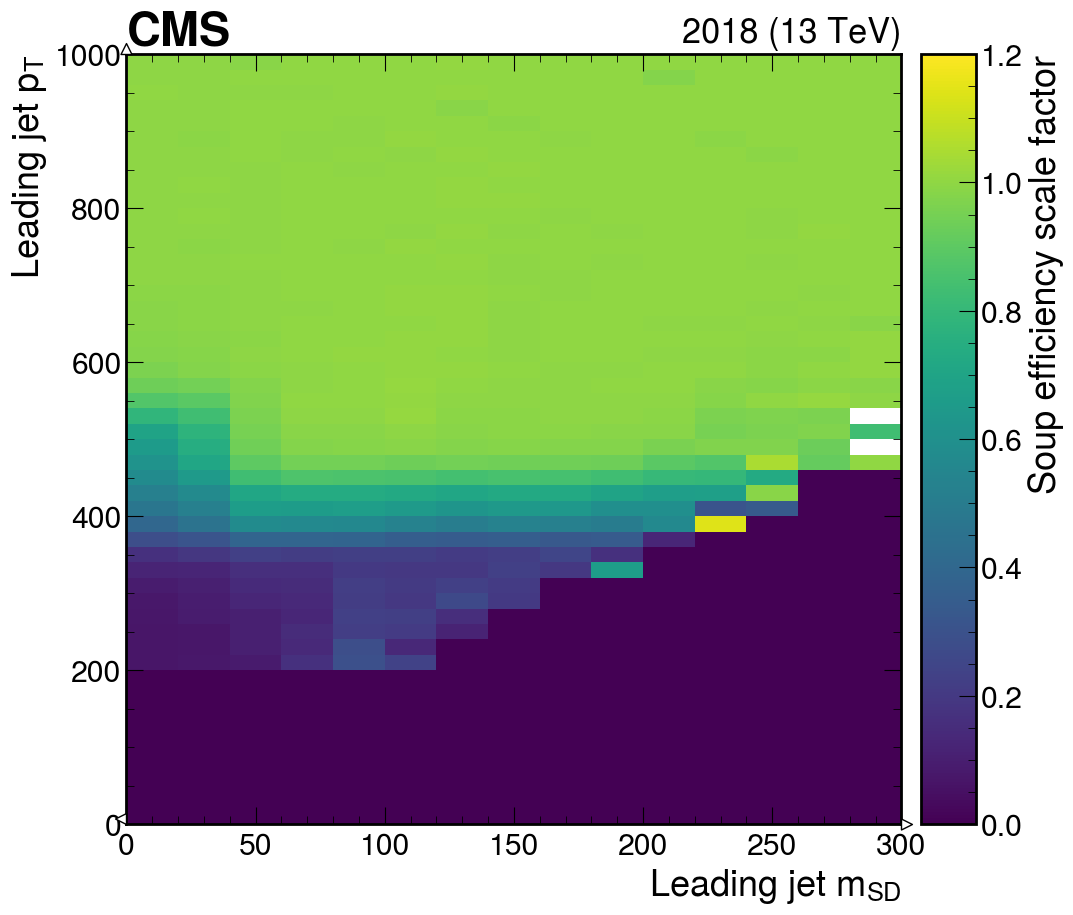

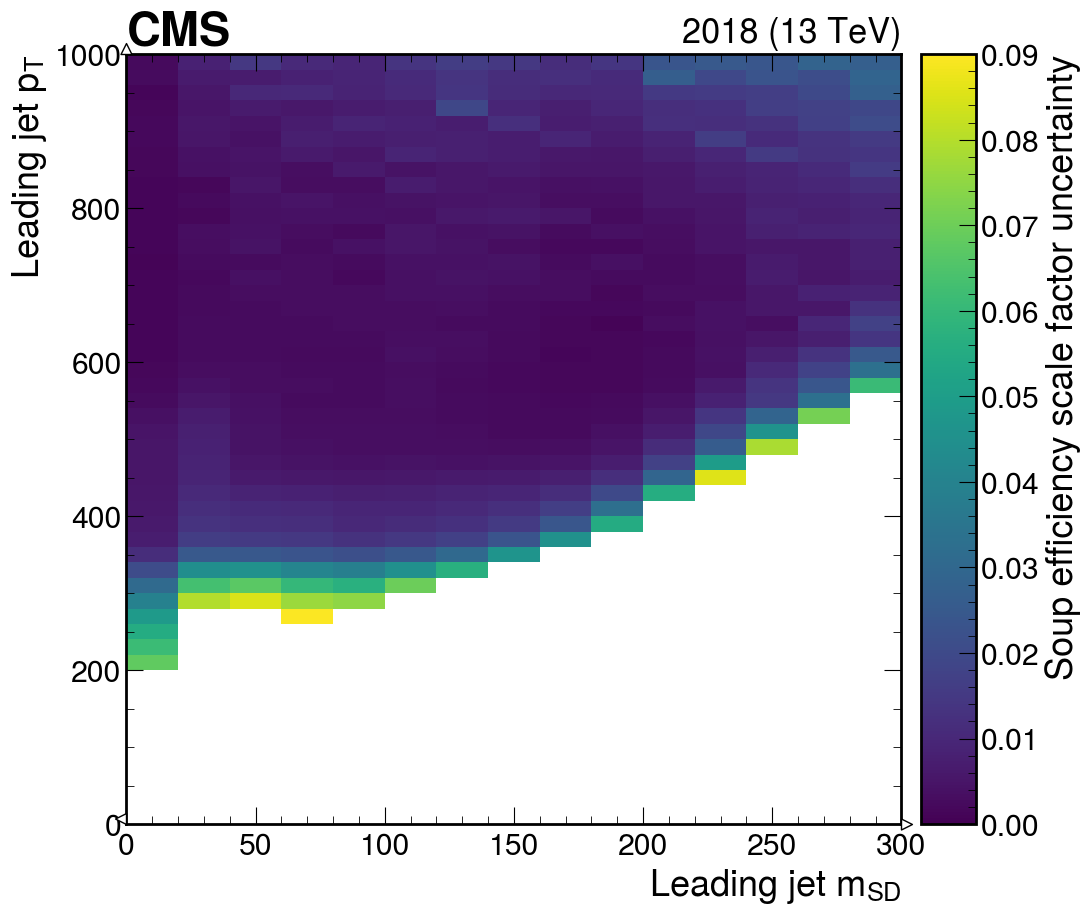

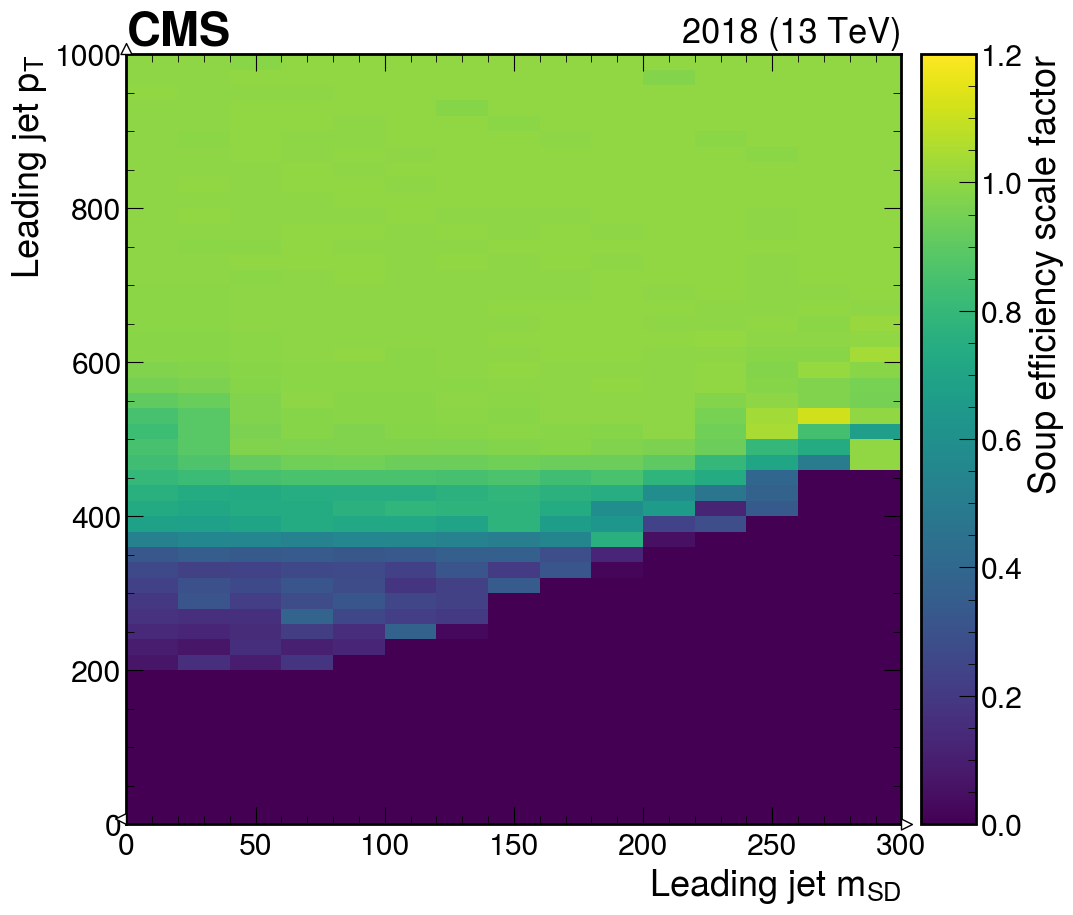

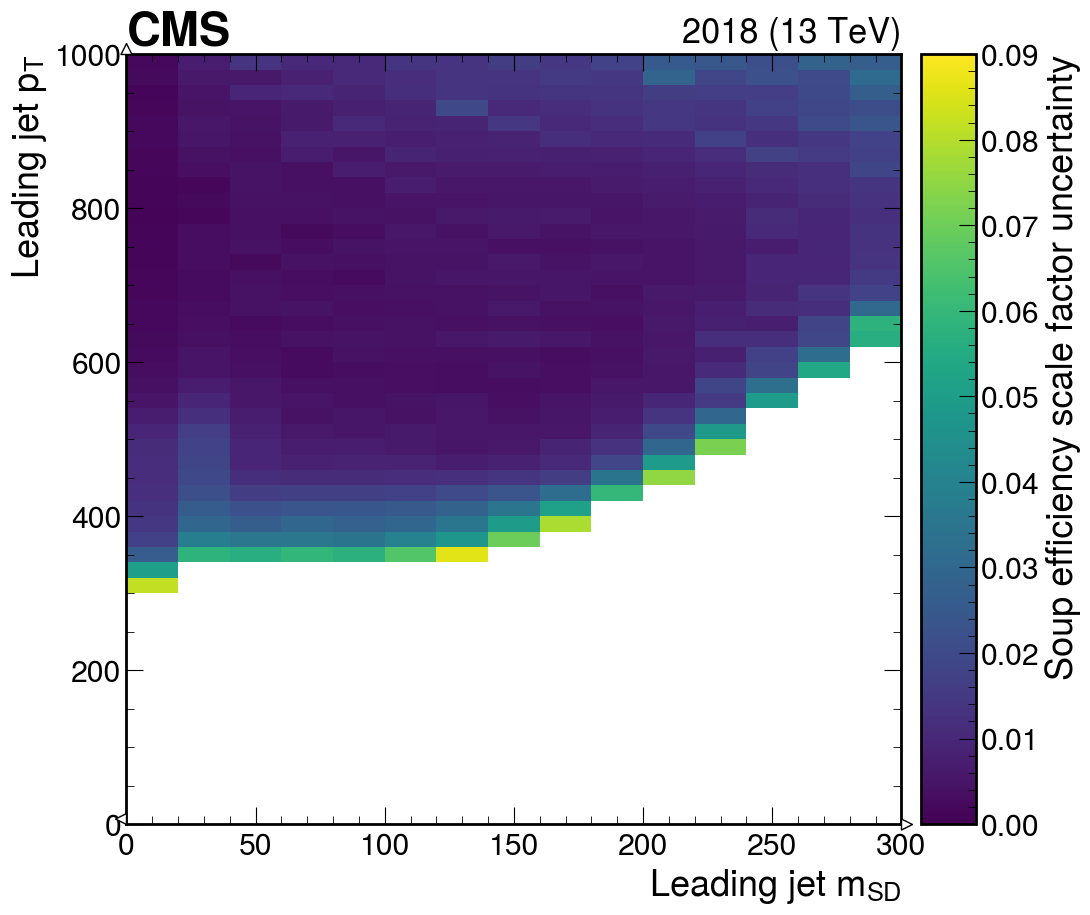

In [42]:
y_top, x_top = derive_sf(out_top)
y_qcd, x_qcd = derive_sf(out_qcd)

In [22]:
residual = np.abs(y_top - y_qcd) - np.sqrt(np.power(x_top,2) + np.power(x_qcd,2))

In [25]:
residual.shape

(50, 15)

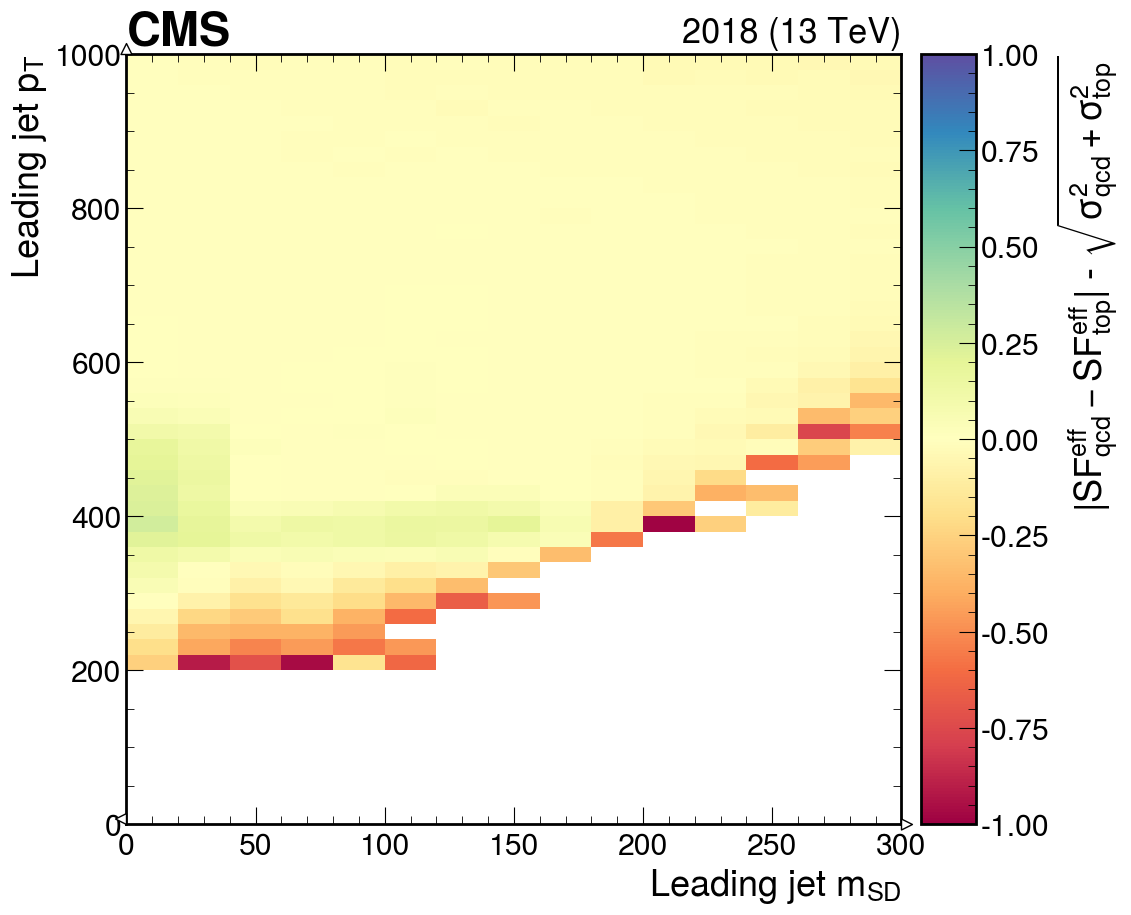

In [44]:
# Compute the residual
residual = np.abs(y_top.values() - y_qcd.values()) - np.sqrt(np.power(x_top.values(), 2) + np.power(x_qcd.values(), 2))
# residual = np.nan_to_num(residual, nan=0.0)

# Create a new histogram for the residual
residual_hist = y_top.copy()
residual_hist[...] = residual

# Plot the residual histogram
fig, ax = plt.subplots()
artist = mplhep.hist2dplot(residual_hist.project(1, 0), ax=ax, cmin=-1, cmax=1, cmap='Spectral')
artist.cbar.set_label(r"$|SF^{eff}_{qcd} - SF^{eff}_{top}|$ - $\sqrt{\sigma_{qcd}^2+\sigma_{top}^2}$")
mplhep.cms.label(ax=ax, data=True, year=year)
fig.savefig(f"scalefactor_residual_{year}.pdf", bbox_inches='tight')

--------

In [4]:
from coffea.util import load

# Initialize the output histogram dictionary
out = None

# Combine all QCD and data files
all_files = top_files + data_files

for f in all_files:
    # Load the histogram dictionary from the .coffea file
    tmp = load(f)[0]  # [0] to get the histogram dictionary

    if out is None:
        # If 'out' is empty, initialize it with the first histogram dictionary
        out = tmp
    else:
        # Add histograms from 'tmp' to 'out'
        for key in tmp:
            if key in out:
                out[key].add(tmp[key])  # Combine histograms
            else:
                out[key] = tmp[key]  # Add new histograms


/tmp/ipykernel_2485394/896856200.py:42: RuntimeWarning: invalid value encountered in divide
  x[...] = (scalefactor_up - scalefactor_dn) / 2 / scalefactor


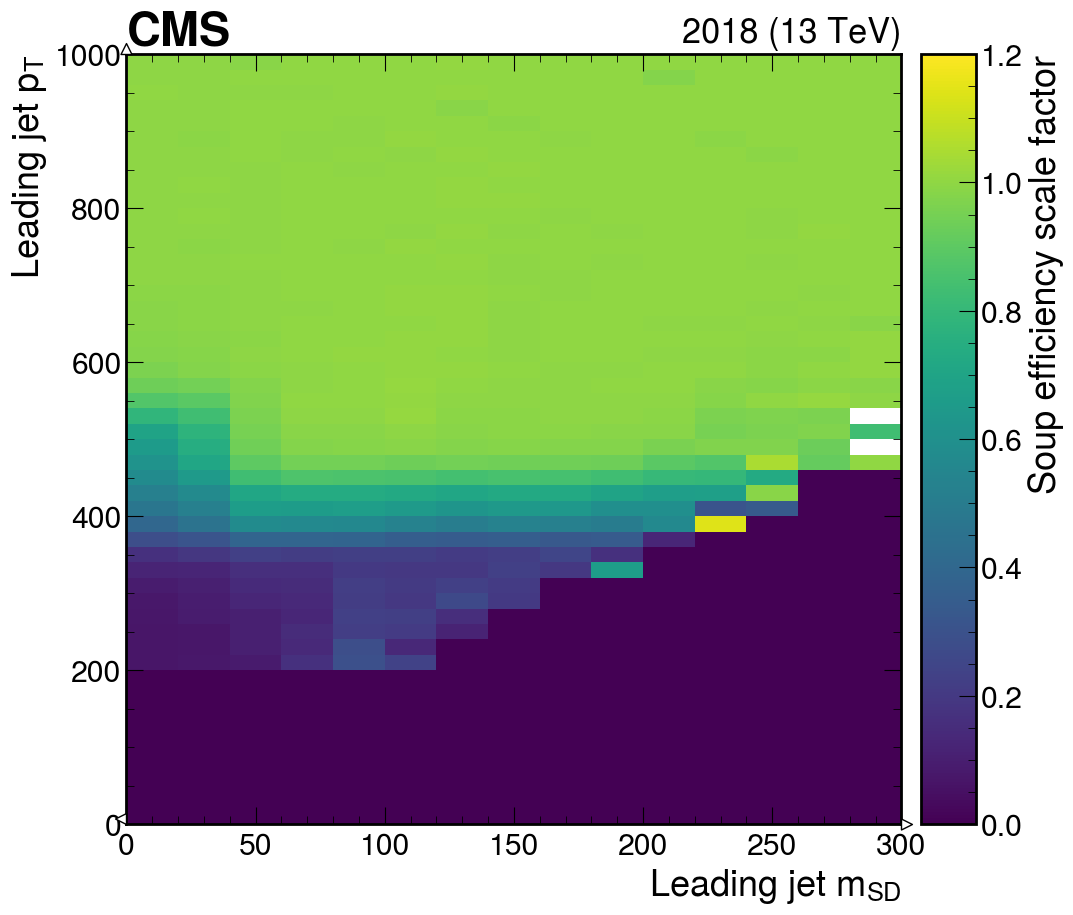

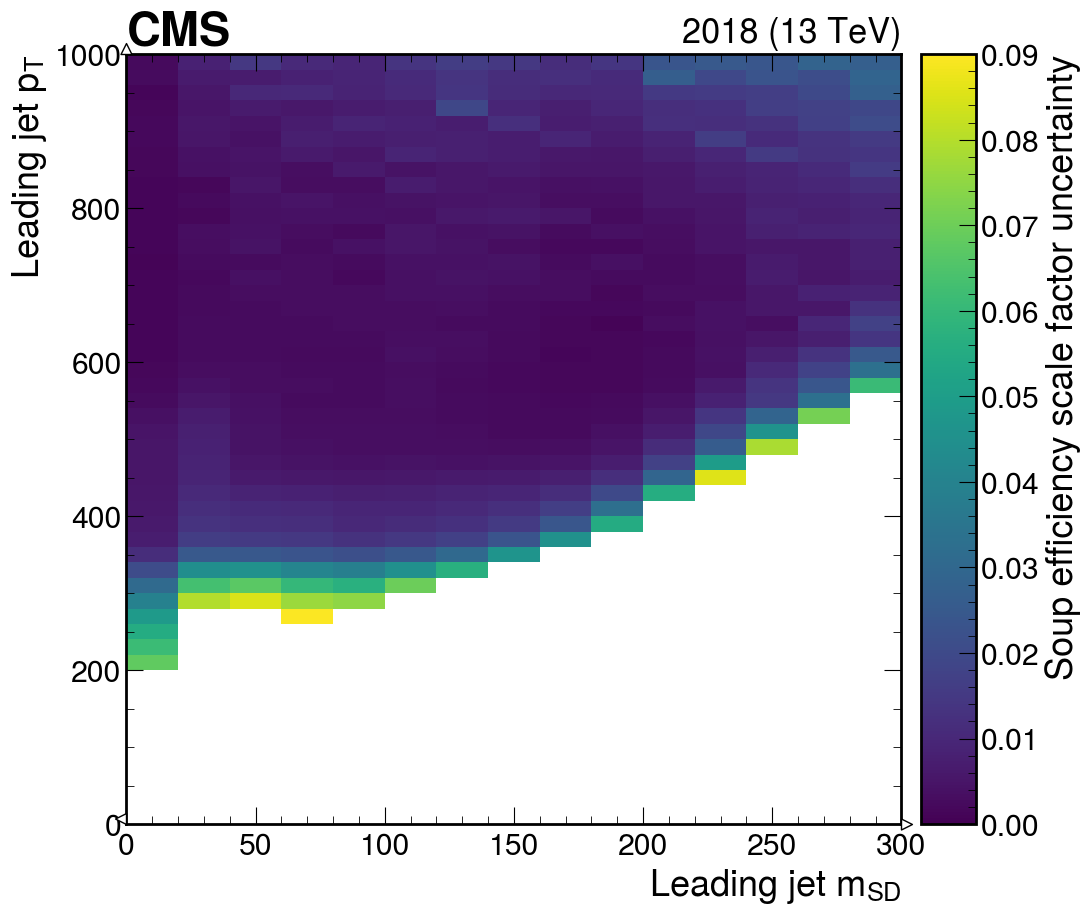

In [ ]:
from coffea.hist import clopper_pearson_interval
num = (
    out["trigger_inclusive"]
    .integrate("trigger", "all")
    .integrate("dataset")
    .sum("ddb")
    .rebin("pt", 2)
    .rebin("msd", 2)
)
denom = (
    out["trigger_exclusive"]
    .integrate("trigger", "none")
    .integrate("dataset")
    .sum("ddb")
    .rebin("pt", 2)
    .rebin("msd", 2)
)
alldata = re.compile("(Run)?201[678]")
rdata = (
    num.integrate("era", alldata).to_hist().view() 
    / np.maximum(1, denom.integrate("era", alldata).to_hist().view())
)
rdata_unc = clopper_pearson_interval(
    num.integrate("era", alldata).to_hist().view(),
    denom.integrate("era", alldata).to_hist().view(),
)

rmc = (
    num.integrate("era", "MC").to_hist().view()
    / np.maximum(1, denom.integrate("era", "MC").to_hist().view())
)
rmc_unc = clopper_pearson_interval(
    num.integrate("era", "MC").to_hist().view(),
    denom.integrate("era", "MC").to_hist().view(),
)

scalefactor = rdata / np.where(rmc == 0, 1., rmc)
scalefactor_up = rdata_unc[1] / np.where(rmc_unc[0] == 0, np.inf, rmc_unc[0])
scalefactor_dn = rdata_unc[0] / np.where(rmc_unc[1] == 0, 1., rmc_unc[1])
x = num.integrate("era").to_hist()
y = x.copy()
x[...] = (scalefactor_up - scalefactor_dn) / 2 / scalefactor
y[...] = scalefactor

fig, ax = plt.subplots()
artist = mplhep.hist2dplot(y.project(1, 0), ax=ax, cmin=0, cmax=1.2)
artist.cbar.set_label("Soup efficiency scale factor")
mplhep.cms.label(ax=ax, data=True, year=year)
fig.savefig(f"scalefactor_soup_{year}.pdf")

fig, ax = plt.subplots()
artist = mplhep.hist2dplot(x.project(1, 0), ax=ax, cmin=0, cmax=0.09)
artist.cbar.set_label("Soup efficiency scale factor uncertainty")
mplhep.cms.label(ax=ax, data=True, year=year)
fig.savefig(f"scalefactor_soup_unc_{year}.pdf")